In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from transformers import AlbertTokenizer, AlbertModel
from tqdm import tqdm
import pickle
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nLibraries imported successfully!")

Using device: cuda
GPU: Tesla T4

Libraries imported successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Shut up/processing/cleaned_label.csv'

In [4]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nFirst few rows:")
print(df.head())

Loading dataset...
Dataset shape: (50000, 2)

Columns: ['review_text', 'sentiment_label']

Sentiment distribution:
sentiment_label
0    25000
1    25000
Name: count, dtype: int64

First few rows:
                                         review_text  sentiment_label
0  Once again Mr. Costner has dragged out a movie...                0
1  This is a pale imitation of 'Officer and a Gen...                0
2  Years ago, when DARLING LILI played on TV, it ...                0
3  I was looking forward to this movie. Trustwort...                0
4  First of all, I would like to say that I am a ...                0


In [5]:
# Model name - ALBERT Base v2
MODEL_NAME = 'albert-base-v2'

print(f"Loading ALBERT model: {MODEL_NAME}")
print("Note: ALBERT (A Lite BERT) uses parameter sharing")
print("      - Cross-layer parameter sharing")
print("      - Factorized embedding parameterization")
print("      - Only 12M parameters (10x smaller than BERT!)")
print("      - SOP (Sentence Order Prediction) instead of NSP\n")

# Load tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained(MODEL_NAME)
model = AlbertModel.from_pretrained(MODEL_NAME)

# Move to device
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully!")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Hidden size: {model.config.hidden_size}")
print(f"Number of layers: {model.config.num_hidden_layers}")
print(f"Number of attention heads: {model.config.num_attention_heads}")
print(f"Total parameters: ~12M (vs BERT's 110M)")

Loading ALBERT model: albert-base-v2
Note: ALBERT (A Lite BERT) uses parameter sharing
      - Cross-layer parameter sharing
      - Factorized embedding parameterization
      - Only 12M parameters (10x smaller than BERT!)
      - SOP (Sentence Order Prediction) instead of NSP



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Model loaded successfully!
Vocabulary size: 30000
Hidden size: 768
Number of layers: 12
Number of attention heads: 12
Total parameters: ~12M (vs BERT's 110M)


In [6]:
def get_albert_embedding(text, tokenizer, model, device, max_length=128):
    """
    Extract ALBERT [CLS] token embedding

    Args:
        text: str - Input text
        tokenizer: ALBERT tokenizer
        model: ALBERT model
        device: torch device
        max_length: int - Max sequence length

    Returns:
        numpy array: 768-dimensional embedding vector
    """
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get embeddings
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract [CLS] token embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

    return cls_embedding.cpu().numpy().flatten()

print("Embedding extraction function defined!")

# Test on sample text
sample_text = "This movie is absolutely fantastic!"
sample_embedding = get_albert_embedding(sample_text, tokenizer, model, device)
print(f"\nSample text: '{sample_text}'")
print(f"Sample embedding shape: {sample_embedding.shape}")
print(f"Sample embedding preview (first 10 values): {sample_embedding[:10]}")

Embedding extraction function defined!

Sample text: 'This movie is absolutely fantastic!'
Sample embedding shape: (768,)
Sample embedding preview (first 10 values): [ 1.2281948   0.21141887 -0.35196608 -0.08717178 -1.3061831  -0.9866795
  0.5482182  -1.3237835   0.07202405  0.28317437]


In [7]:
# Parameters
MAX_LENGTH = 128
BATCH_SIZE = 32  # Process in batches to save memory

print("Extracting ALBERT embeddings for all documents...")
print(f"Model: {MODEL_NAME}")
print(f"Max length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total documents: {len(df)}\n")

embeddings = []

# Process in batches
for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch_texts = df['review_text'].iloc[i:i+BATCH_SIZE].values

    for text in batch_texts:
        embedding = get_albert_embedding(str(text), tokenizer, model, device, MAX_LENGTH)
        embeddings.append(embedding)

# Convert to numpy array
embeddings = np.array(embeddings)

print(f"\nEmbeddings extracted!")
print(f"Shape: {embeddings.shape}")
print(f"Each document: {embeddings.shape[1]}-dimensional vector")

Extracting ALBERT embeddings for all documents...
Model: albert-base-v2
Max length: 128
Batch size: 32
Total documents: 50000



100%|██████████| 1563/1563 [10:27<00:00,  2.49it/s]



Embeddings extracted!
Shape: (50000, 768)
Each document: 768-dimensional vector


In [8]:
# Create output directory
output_dir = '/content/drive/MyDrive/Shut up/models/albert_embeddings'
os.makedirs(output_dir, exist_ok=True)

# Save embeddings
embeddings_path = os.path.join(output_dir, 'albert_embeddings.npy')
np.save(embeddings_path, embeddings)
print(f"Embeddings saved: {embeddings_path}")

# Save labels
labels_path = os.path.join(output_dir, 'labels.npy')
np.save(labels_path, df['sentiment_label'].values)
print(f"Labels saved: {labels_path}")

# Save metadata
metadata = {
    'model_name': MODEL_NAME,
    'model_type': 'albert-base-v2',
    'hidden_size': model.config.hidden_size,
    'max_length': MAX_LENGTH,
    'num_documents': len(embeddings),
    'embedding_shape': embeddings.shape,
    'extraction_method': '[CLS] token from last_hidden_state',
    'parameters': '~12M (parameter sharing)',
    'notes': 'ALBERT: Cross-layer parameter sharing, factorized embeddings, SOP task'
}

metadata_path = os.path.join(output_dir, 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Metadata saved: {metadata_path}")

print("\n" + "="*80)
print("All files saved successfully!")
print("="*80)
print(f"\nOutput directory: {output_dir}")
print(f"Files:")
print(f"  - albert_embeddings.npy    (Embeddings: {embeddings.shape})")
print(f"  - labels.npy               (Sentiment labels)")
print(f"  - metadata.pkl             (Model metadata)")

Embeddings saved: /content/drive/MyDrive/Shut up/models/albert_embeddings/albert_embeddings.npy
Labels saved: /content/drive/MyDrive/Shut up/models/albert_embeddings/labels.npy
Metadata saved: /content/drive/MyDrive/Shut up/models/albert_embeddings/metadata.pkl

All files saved successfully!

Output directory: /content/drive/MyDrive/Shut up/models/albert_embeddings
Files:
  - albert_embeddings.npy    (Embeddings: (50000, 768))
  - labels.npy               (Sentiment labels)
  - metadata.pkl             (Model metadata)


In [9]:
# Load saved embeddings
print("Loading saved embeddings...\n")

loaded_embeddings = np.load(embeddings_path)
loaded_labels = np.load(labels_path)

with open(metadata_path, 'rb') as f:
    loaded_metadata = pickle.load(f)

print(f"✓ Embeddings loaded: {loaded_embeddings.shape}")
print(f"✓ Labels loaded: {loaded_labels.shape}")
print(f"\n✓ Metadata:")
for key, value in loaded_metadata.items():
    print(f"    {key}: {value}")

# Verify integrity
print(f"\n✓ Verification:")
print(f"    Embeddings match: {np.allclose(embeddings, loaded_embeddings)}")
print(f"    Labels match: {np.array_equal(df['sentiment_label'].values, loaded_labels)}")

Loading saved embeddings...

✓ Embeddings loaded: (50000, 768)
✓ Labels loaded: (50000,)

✓ Metadata:
    model_name: albert-base-v2
    model_type: albert-base-v2
    hidden_size: 768
    max_length: 128
    num_documents: 50000
    embedding_shape: (50000, 768)
    extraction_method: [CLS] token from last_hidden_state
    parameters: ~12M (parameter sharing)
    notes: ALBERT: Cross-layer parameter sharing, factorized embeddings, SOP task

✓ Verification:
    Embeddings match: True
    Labels match: True


Embedding Statistics:

Shape: (50000, 768)
Mean: -0.0289
Std: 1.2519
Min: -11.1867
Max: 18.2245


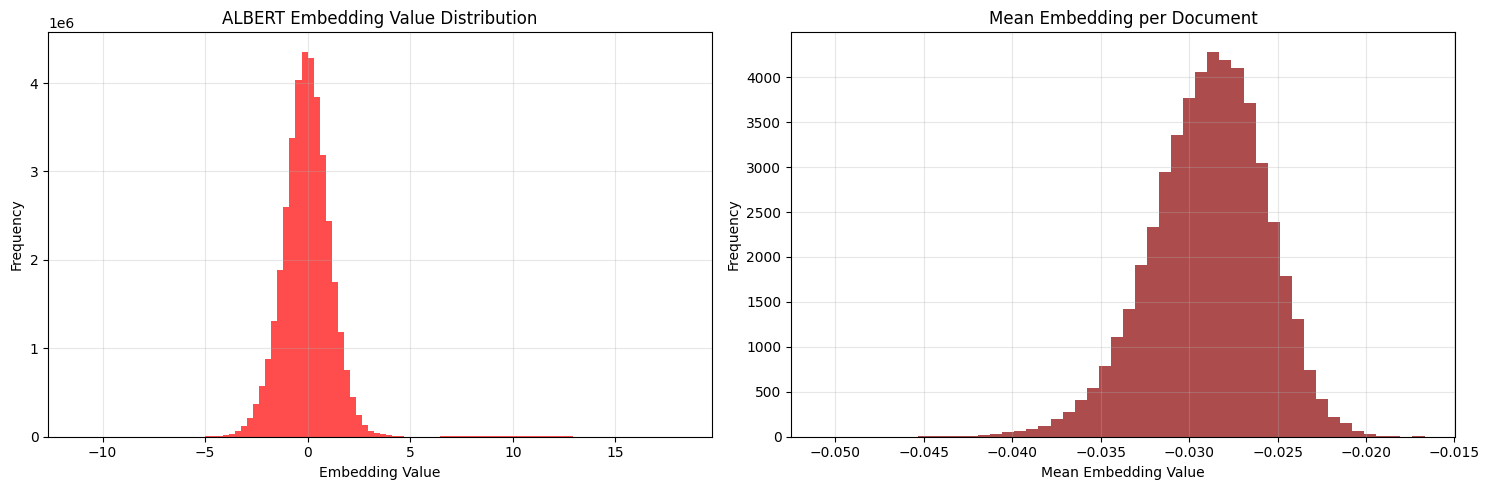


Statistics plotted!


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Embedding Statistics:\n")

# Basic stats
print(f"Shape: {embeddings.shape}")
print(f"Mean: {embeddings.mean():.4f}")
print(f"Std: {embeddings.std():.4f}")
print(f"Min: {embeddings.min():.4f}")
print(f"Max: {embeddings.max():.4f}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(embeddings.flatten(), bins=100, alpha=0.7, color='red')
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('ALBERT Embedding Value Distribution')
axes[0].grid(True, alpha=0.3)

# Mean embedding per document
mean_embeddings = embeddings.mean(axis=1)
axes[1].hist(mean_embeddings, bins=50, alpha=0.7, color='darkred')
axes[1].set_xlabel('Mean Embedding Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mean Embedding per Document')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistics plotted!")

Performing PCA on 1000 samples...
Explained variance: 20.83%


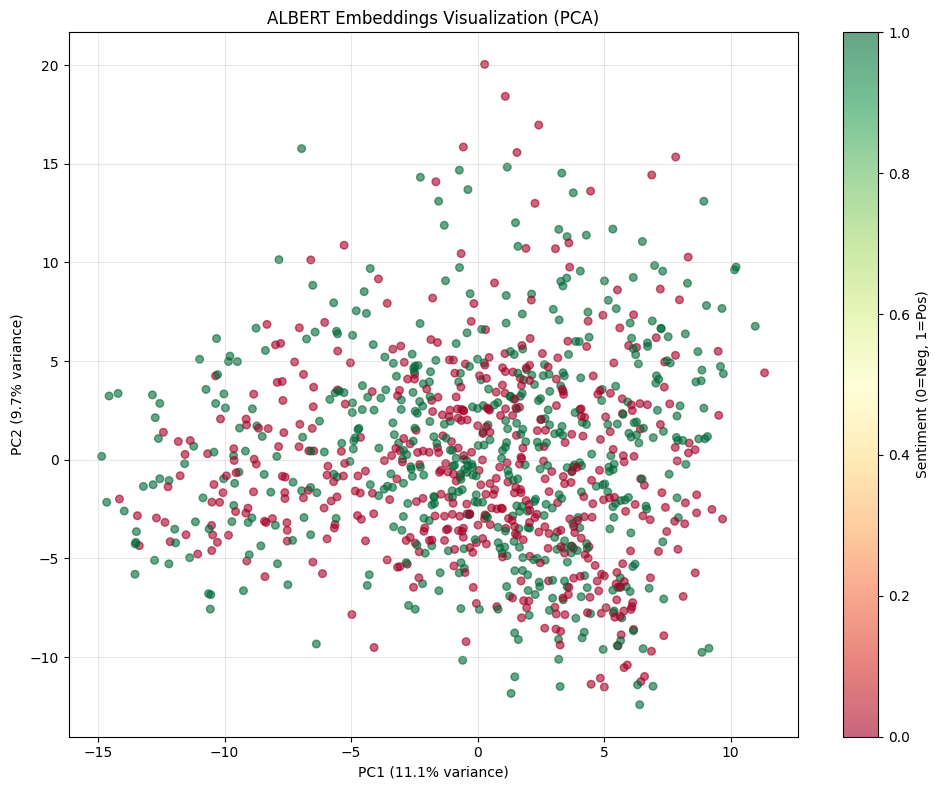


Visualization complete!


In [11]:
from sklearn.decomposition import PCA

# Sample for visualization
sample_size = 1000
indices = np.random.choice(len(embeddings), size=min(sample_size, len(embeddings)), replace=False)

sample_embeddings = embeddings[indices]
sample_labels = df['sentiment_label'].iloc[indices].values

# PCA reduction to 2D
print(f"Performing PCA on {len(sample_embeddings)} samples...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sample_embeddings)

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=sample_labels,
    cmap='RdYlGn',
    alpha=0.6,
    s=30
)
plt.colorbar(scatter, label='Sentiment (0=Neg, 1=Pos)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('ALBERT Embeddings Visualization (PCA)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVisualization complete!")

In [12]:
print("\n" + "="*80)
print("ALBERT vs BERT Differences")
print("="*80)

comparison = {
    'Feature': [
        'Full Name',
        'Parameters (Base)',
        'Embedding Size',
        'Hidden Size',
        'Parameter Sharing',
        'Embedding Factorization',
        'Training Task',
        'Memory Usage',
        'Training Speed',
        'Performance'
    ],
    'BERT': [
        'Bidirectional Encoder Representations from Transformers',
        '110M',
        '768',
        '768',
        'No sharing',
        'No factorization',
        'MLM + NSP',
        'High',
        'Slower',
        'Good'
    ],
    'ALBERT': [
        'A Lite BERT',
        '12M (10x smaller!)',
        '128 (factorized)',
        '768',
        'Cross-layer parameter sharing',
        'Yes (E=128, H=768)',
        'MLM + SOP',
        'Low',
        'Faster',
        'Better (with fewer params!)'
    ]
}

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("Key Innovations of ALBERT:")
print("="*80)
print("\n1. Factorized Embedding Parameterization:")
print("   - Separates embedding size (E) from hidden size (H)")
print("   - E=128, H=768 instead of E=H=768")
print("   - Reduces parameters: 30000*768 → 30000*128 + 128*768")

print("\n2. Cross-Layer Parameter Sharing:")
print("   - All layers share the same parameters")
print("   - Only 1 transformer layer is stored")
print("   - Massive parameter reduction")

print("\n3. Sentence Order Prediction (SOP):")
print("   - Replaces NSP (Next Sentence Prediction)")
print("   - More challenging: predict if sentence order is correct")
print("   - Better inter-sentence coherence understanding")

print("\n" + "="*80)
print("Result: 10x fewer parameters, better performance!")
print("="*80)


ALBERT vs BERT Differences
                Feature                                                    BERT                        ALBERT
              Full Name Bidirectional Encoder Representations from Transformers                   A Lite BERT
      Parameters (Base)                                                    110M            12M (10x smaller!)
         Embedding Size                                                     768              128 (factorized)
            Hidden Size                                                     768                           768
      Parameter Sharing                                              No sharing Cross-layer parameter sharing
Embedding Factorization                                        No factorization            Yes (E=128, H=768)
          Training Task                                               MLM + NSP                     MLM + SOP
           Memory Usage                                                    High             

In [13]:
# Calculate parameter counts
print("\n" + "="*80)
print("Parameter Efficiency Analysis")
print("="*80)

vocab_size = 30000
hidden_size = 768
embedding_size_albert = 128
num_layers = 12

# BERT embedding parameters
bert_embedding_params = vocab_size * hidden_size
print(f"\nBERT Embedding Parameters:")
print(f"  {vocab_size:,} × {hidden_size} = {bert_embedding_params:,}")

# ALBERT embedding parameters (factorized)
albert_vocab_to_embed = vocab_size * embedding_size_albert
albert_embed_to_hidden = embedding_size_albert * hidden_size
albert_embedding_params = albert_vocab_to_embed + albert_embed_to_hidden
print(f"\nALBERT Embedding Parameters (Factorized):")
print(f"  Vocab→Embed: {vocab_size:,} × {embedding_size_albert} = {albert_vocab_to_embed:,}")
print(f"  Embed→Hidden: {embedding_size_albert} × {hidden_size} = {albert_embed_to_hidden:,}")
print(f"  Total: {albert_embedding_params:,}")
print(f"  Reduction: {bert_embedding_params / albert_embedding_params:.1f}x")

# Layer parameters (simplified)
approx_layer_params = 7_000_000  # Approximate per layer

bert_total = bert_embedding_params + (num_layers * approx_layer_params)
albert_total = albert_embedding_params + approx_layer_params  # Shared layers

print(f"\nTotal Approximate Parameters:")
print(f"  BERT: {bert_total:,} (~110M)")
print(f"  ALBERT: {albert_total:,} (~12M)")
print(f"  Overall Reduction: {bert_total / albert_total:.1f}x")

print("\n" + "="*80)
print("ALBERT achieves ~10x parameter reduction while maintaining performance!")
print("="*80)


Parameter Efficiency Analysis

BERT Embedding Parameters:
  30,000 × 768 = 23,040,000

ALBERT Embedding Parameters (Factorized):
  Vocab→Embed: 30,000 × 128 = 3,840,000
  Embed→Hidden: 128 × 768 = 98,304
  Total: 3,938,304
  Reduction: 5.9x

Total Approximate Parameters:
  BERT: 107,040,000 (~110M)
  ALBERT: 10,938,304 (~12M)
  Overall Reduction: 9.8x

ALBERT achieves ~10x parameter reduction while maintaining performance!


In [14]:
print("\n" + "="*80)
print("ALBERT EMBEDDING EXTRACTION SUMMARY")
print("="*80)

print(f"\n Model: {MODEL_NAME}")
print(f" Architecture: A Lite BERT (Parameter-efficient)")
print(f" Embedding dimension: {embeddings.shape[1]}")
print(f" Total documents: {embeddings.shape[0]:,}")
print(f" Total size: {embeddings.nbytes / (1024**2):.2f} MB")
print(f" Parameters: Only 12M (10x smaller than BERT!)")

print(f"\n Files saved:")
print(f"   {output_dir}/")
print(f"   ├── albert_embeddings.npy  ({embeddings.shape})")
print(f"   ├── labels.npy             ({loaded_labels.shape})")
print(f"   └── metadata.pkl")

print(f"\n Usage:")
print(f"   These embeddings can be used with any classifier:")
print(f"   - Logistic Regression")
print(f"   - SVM")
print(f"   - Random Forest")
print(f"   - Neural Networks")

print(f"\n Load embeddings:")
print(f"   X = np.load('{embeddings_path}')")
print(f"   y = np.load('{labels_path}')")

print(f"\n Why ALBERT:")
print(f"   - 10x fewer parameters than BERT")
print(f"   - Parameter sharing across layers")
print(f"   - Factorized embeddings")
print(f"   - Better SOP task vs NSP")
print(f"   - Faster training, less memory")
print(f"   - Often matches or exceeds BERT performance")

print("\n" + "="*80)
print(" ALBERT embedding extraction complete!")
print("="*80)


ALBERT EMBEDDING EXTRACTION SUMMARY

 Model: albert-base-v2
 Architecture: A Lite BERT (Parameter-efficient)
 Embedding dimension: 768
 Total documents: 50,000
 Total size: 146.48 MB
 Parameters: Only 12M (10x smaller than BERT!)

 Files saved:
   /content/drive/MyDrive/Shut up/models/albert_embeddings/
   ├── albert_embeddings.npy  ((50000, 768))
   ├── labels.npy             ((50000,))
   └── metadata.pkl

 Usage:
   These embeddings can be used with any classifier:
   - Logistic Regression
   - SVM
   - Random Forest
   - Neural Networks

 Load embeddings:
   X = np.load('/content/drive/MyDrive/Shut up/models/albert_embeddings/albert_embeddings.npy')
   y = np.load('/content/drive/MyDrive/Shut up/models/albert_embeddings/labels.npy')

 Why ALBERT:
   - 10x fewer parameters than BERT
   - Parameter sharing across layers
   - Factorized embeddings
   - Better SOP task vs NSP
   - Faster training, less memory
   - Often matches or exceeds BERT performance

 ALBERT embedding extraction